Link to R sources: https://github.com/MatrixNorm/kaggle/tree/master/R_sources/house_prices

### Transforming categorical variable to numeric

Custom "rating transformation" is applied. Algo is:

1. Calculate global distribution of a target variable (price_log).
2. Split it in 4 ranges from low to high. Assign rating to each range: 1, 2, 3, 4.
3. For a given categ attribute find marginal target distributions for it's values.
4. Calculate mean rating relative to marginal distribution.

In [91]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))

house_prices <- source('main.R', local = TRUE)$value

trans <- house_prices$trans
get_character_colnames <- house_prices$helpers$get_character_colnames

combinedDataset <-
    house_prices$helpers$load_data() %>%
    (house_prices$outliers$remove_outliers) %>%
    (house_prices$missing$fix_all) %>%
    mutate(
        price_log = log(SalePrice)
    ) %>%
    select(-SalePrice)

test_that("should be no NA values except `price_log` column", {
    expect_equal(sum(is.na(combinedDataset %>% select(-price_log))), 0)
})

combinedDataset %>% dim %>% show_list

2917 82

In [92]:
#  == Global quantiles ==
#
# Find quarter quantiles for price_log
#
globalPriceLogQuantiles <- 
    trans$categ$QuantileRating$calc_quantiles(
        sample = combinedDataset[['price_log']],
        probs = c(0.25, 0.5, 0.75)
    ) 

globalPriceLogQuantiles %>% as_data_frame

,value
25%,11.77471
50%,12.00151
75%,12.27373


In [100]:
# Ratings calculation
#
ratings <- trans$categ$QuantileRating$calc_ratings(
    df = combinedDataset,
    target_var = price_log,
    rating_quantiles = globalPriceLogQuantiles,
    categ_vars = get_character_colnames(combinedDataset)
)    

ratings2 <- trans$categ$calc_ratings(combinedDataset, price_log)    

test_that("should be equal ratings", {
    expect_equal(ratings, ratings2)
})

show_table(ratings1 %>% arrange(var, rating) %>% head(10), cols =2)

var,value,rating
Alley,Grvl,1.500000
Alley,_none_,2.531822
Alley,Pave,2.536585
BldgType,2fmCon,1.580645
BldgType,Duplex,1.692308
BldgType,Twnhs,1.883721
BldgType,1Fam,2.564039
BldgType,TwnhsE,2.622807
BsmtCond,Po,1.000000
BsmtCond,_none_,1.216216


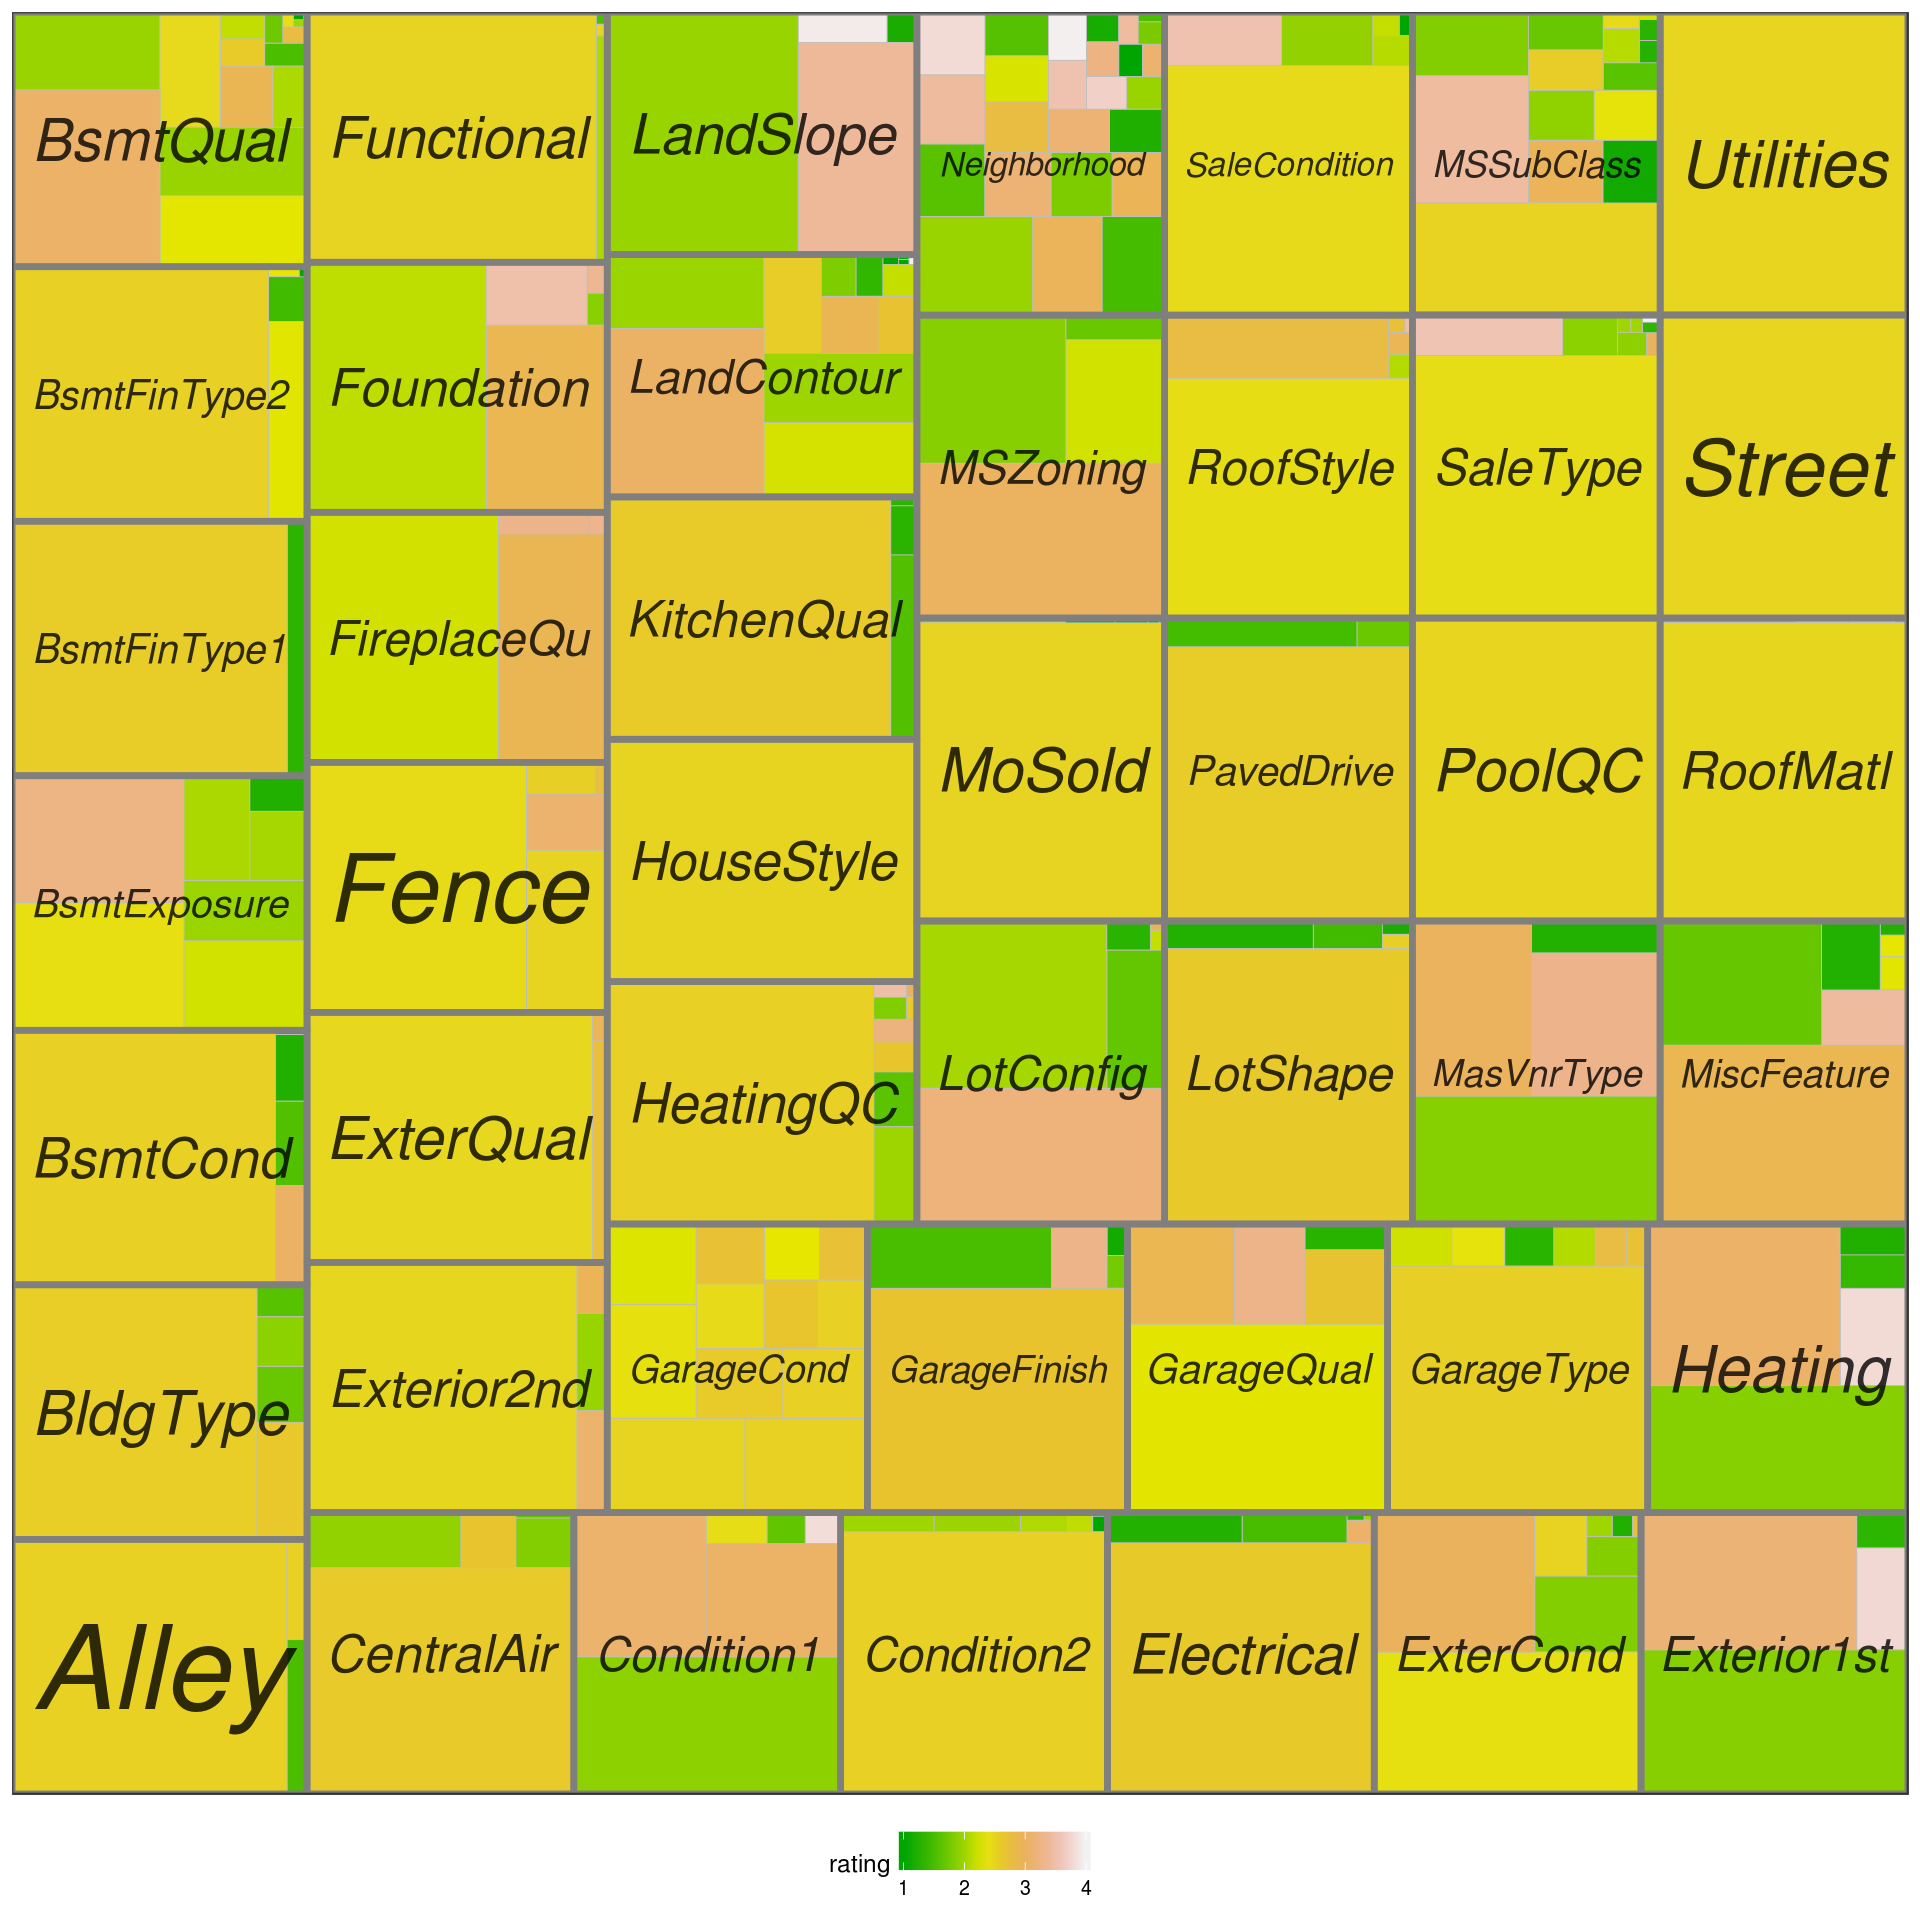

In [106]:
`@@@`(12, 12, 160)
combinedDataset %>% 
select(get_character_colnames(combinedDataset)) %>%
gather(var, value) %>%
group_by(var, value) %>%
count %>%
inner_join(ratings, by=c('var', 'value')) %>%
ggplot(aes(area = n, fill = rating, subgroup = var)) +
geom_treemap() +
geom_treemap_subgroup_border() +
geom_treemap_subgroup_text(
    place = "centre", alpha = 0.8, grow = T, colour = "black", 
    fontface = "italic", padding.x = grid::unit(3, "mm")
) +
scale_fill_gradientn(colours = terrain.colors(10)) +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5))

In [47]:
# Ratings transformation
#
transformedData <- trans$categ$Tran$rating_transform_for_selected(
    data = combinedDataset,
    columns = get_character_colnames(combinedDataset),
    ratings = trans$categ$calc_ratings(combinedDataset, price_log)  
)

transformedData2 <- trans$categ$rating_transform(
    combinedDataset,
    price_log
)

test_that("should be equal", {
    expect_equal(transformedData, transformedData2)
})

test_that("numeric columns should not be affected", {    
    original_numeric_columns <- 
        combinedDataset %>% sapply(is.numeric) %>% which %>% names
    
    expect_equal(
        transformedData %>% select(original_numeric_columns), 
        combinedDataset %>% select(original_numeric_columns)
    )
})

test_that("the only left categ column is dataSource", {    
    expect_equal(
        transformedData %>% select_if(is.character) %>% colnames, 
        "dataSource"
    )
})

house_prices$helpers$utils$frames_diff(transformedData, combinedDataset) %>% head

Alley.1,Alley.2,BldgType.1,BldgType.2,BsmtCond.1,BsmtCond.2,BsmtExposure.1,BsmtExposure.2,BsmtFinType1.1,BsmtFinType1.2,⋯,RoofStyle.1,RoofStyle.2,SaleCondition.1,SaleCondition.2,SaleType.1,SaleType.2,Street.1,Street.2,Utilities.1,Utilities.2
2.531822,_none_,2.564039,1Fam,2.540871,TA,2.320042,No,3.262019,GLQ,⋯,2.418054,Gable,2.451586,Normal,2.421468,WD,2.499311,Pave,2.496911,AllPub
2.531822,_none_,2.564039,1Fam,2.540871,TA,3.295455,Gd,2.231818,ALQ,⋯,2.418054,Gable,2.451586,Normal,2.421468,WD,2.499311,Pave,2.496911,AllPub
2.531822,_none_,2.564039,1Fam,2.540871,TA,2.675439,Mn,3.262019,GLQ,⋯,2.418054,Gable,2.451586,Normal,2.421468,WD,2.499311,Pave,2.496911,AllPub
2.531822,_none_,2.564039,1Fam,3.046154,Gd,2.320042,No,2.231818,ALQ,⋯,2.418054,Gable,1.920792,Abnorml,2.421468,WD,2.499311,Pave,2.496911,AllPub
2.531822,_none_,2.564039,1Fam,2.540871,TA,2.900452,Av,3.262019,GLQ,⋯,2.418054,Gable,2.451586,Normal,2.421468,WD,2.499311,Pave,2.496911,AllPub
2.531822,_none_,2.564039,1Fam,2.540871,TA,2.320042,No,3.262019,GLQ,⋯,2.418054,Gable,2.451586,Normal,2.421468,WD,2.499311,Pave,2.496911,AllPub


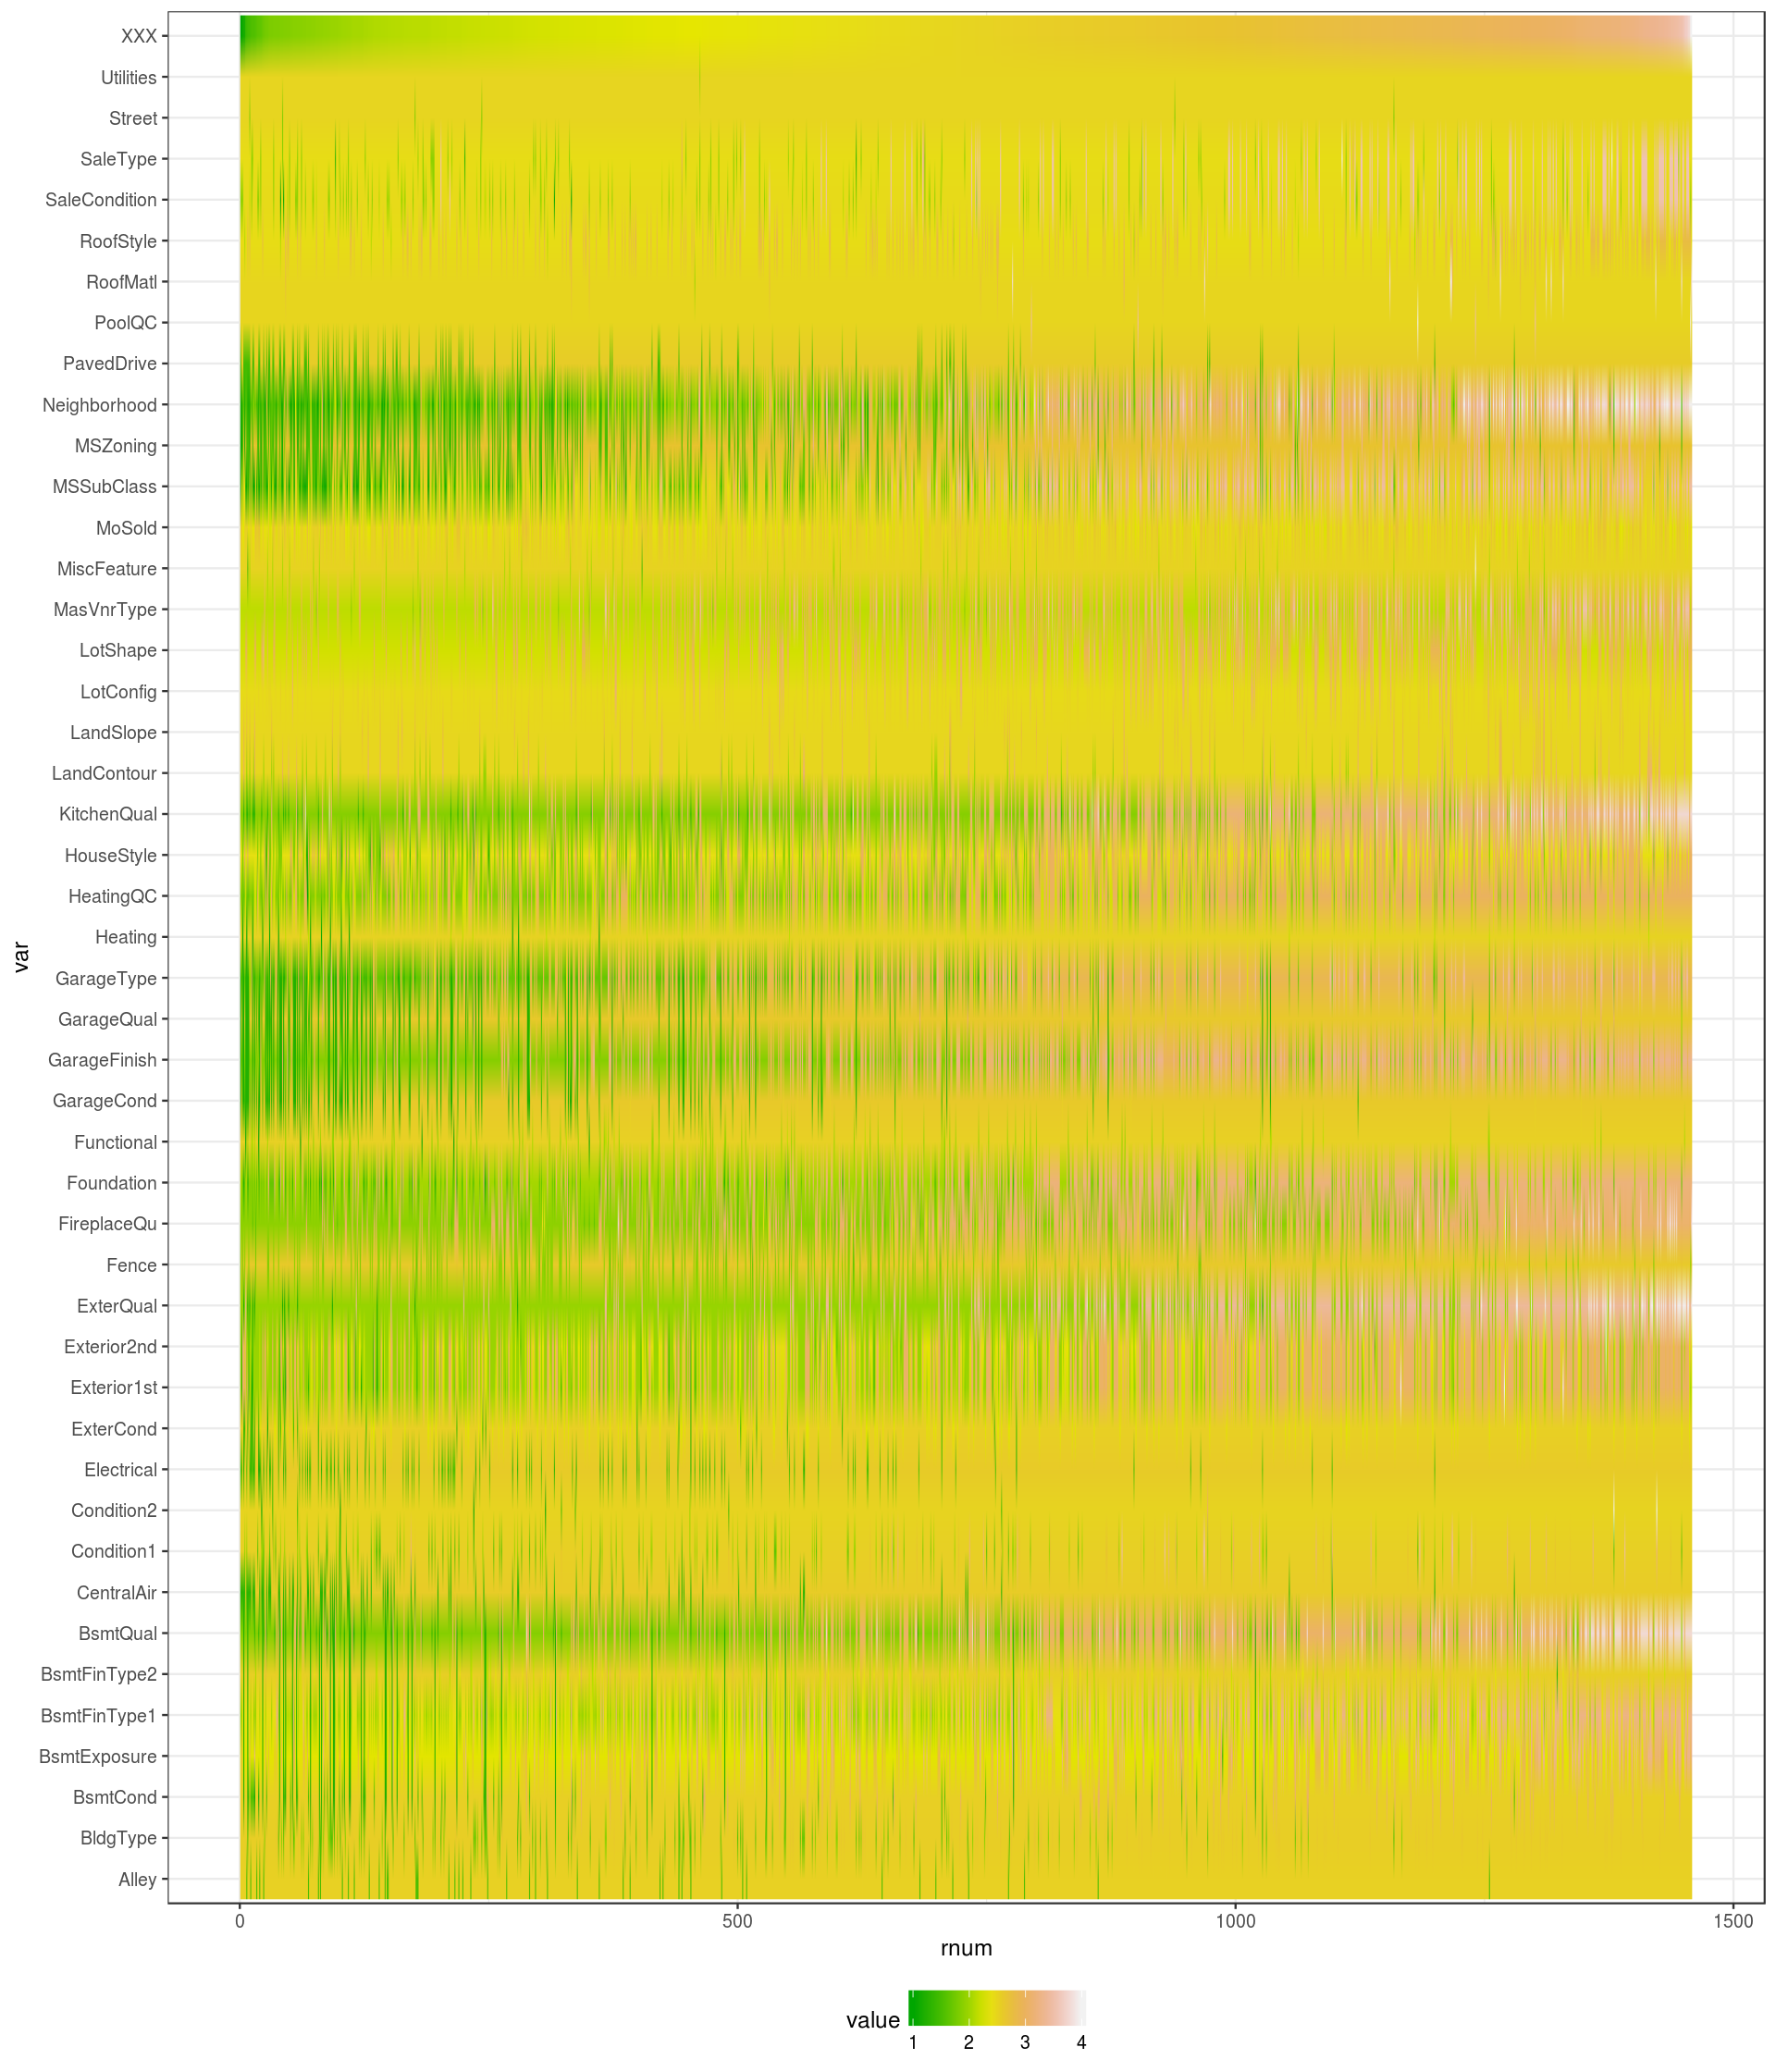

In [107]:
`@@@`(12, 14, 160)
transformedData %>% 
select(one_of(get_character_colnames(combinedDataset)), price_log) %>% 
filter(!is.na(price_log)) %>%
arrange(price_log) %>%
mutate(
    rnum = row_number(),
    `XXX` = (3*price_log + max(price_log) - 4*min(price_log)) / (max(price_log) - min(price_log))
) %>%
select(-price_log) %>%
gather(var, value, -rnum) %>%
ggplot() + 
geom_raster(aes(x=rnum, y=var, fill=value), interpolate=TRUE) +
scale_fill_gradientn(colours = terrain.colors(10)) +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5))

In [109]:
# Timing different implementations
#

rating_transform_for_selected <- trans$categ$Tran$rating_transform_for_selected
rating_transform_for_selected2 <- trans$categ$Tran$rating_transform_for_selected2
rating_transform_for_selected3 <- trans$categ$Tran$rating_transform_for_selected3

ratings <- trans$categ$calc_ratings(combinedDataset, price_log)  

system.time({
    df1 <- rating_transform_for_selected(
        data = combinedDataset,
        columns = get_character_colnames(combinedDataset),
        ratings = ratings
    )
})

system.time({
    df2 <- rating_transform_for_selected2(
        data = combinedDataset,
        columns = get_character_colnames(combinedDataset),
        ratings = ratings
    )
})

system.time({
    df3 <- rating_transform_for_selected3(
        data = combinedDataset,
        columns = get_character_colnames(combinedDataset),
        ratings = ratings
    )
})

test_that("should be equal", {
    expect_equal(df1, df2)
})

test_that("should be equal", {
    expect_equal(df2, df3)
})

   user  system elapsed 
  0.061   0.000   0.060 

   user  system elapsed 
  0.816   0.000   0.816 

   user  system elapsed 
  0.634   0.000   0.634 